# COGS 108 - EDA Checkpoint

# Names

- Zhuoran Li
- Zhaoyi Yu
- Zecheng Li
- Gao Mo

<a id='research_question'></a>
# Research Question

Obesity is a topic that has been on the rise recently as people are becoming more and more concerned about their health. Are obesity rates related to people's living conditions? Here, we consider living conditions as determined by people's income levels, employment status, and weather conditions as indicated by the latitude and longitude of the United States. We used each U.S. state as a unit and collected data from each state over years to examine the factors influencing obesity.

# Setup

In [1]:
%matplotlib inline
import pandas as pd 
import openpyxl
import os 
import numpy as np
import requests
import geopandas as gpd
import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest
import seaborn as sns
import matplotlib.pyplot as plt

/Users/gaomo/opt/anaconda3/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


# Data Cleaning

# Datasets：
Dataset Name: `US Unemployment Rate by County, 1990-2016`
- Link to the dataset: https://www.kaggle.com/jayrav13/unemployment-by-county-us?select=output.csv
- Number of observations: 885548
- Description: The  US Unemployment Rate by County dataset represents the Unemployment Statistics of USA from 1990-2016, broken down by state and month. 

Dataset Name: `United States Mental Illness Rate`
- Link to the dataset： https://www.kaggle.com/bobnis/us-stats-meillness
- Number of observations: First Dataset: 500000; Second Dataset: 500000
- Description: The United States Mental Illness Rate dataset shows the proportion of American people getting mental illness, such as depression and bipolar, broken down by ethnicity, state and gender.

Dataset Name: `Household median income, 2003 - 2016`
- Link to the dataset： https://www.census.gov/data/tables/time-series/demo/income-poverty/historical-income-households.html
- Number of observations: 52 observations per year, 728 observations in total
- Description: The Household median income dataset contains the median household level of income for all states in US ranging from the year 2003 to 2016.

Dataset Name: `Adult Obesity Rate by State, 2003 - 2020`
- Link to the dataset：https://stateofchildhoodobesity.org/adult-obesity/
- Number of observations: 51 observations per year, 867 observations in total
- obesity rate： The state-by-state adult obesity rate data set is collected by the `National Obesity Monitor`, which gathers data on obesity rates in each state over years.

Dataset Name: `Weather CSV File`
- Link to the dataset: https://corgis-edu.github.io/corgis/csv/weather/
- Number of observations: 16742
- Description: The National Weather Service, which is part of the National Oceanic and Atmospheric Administration, offers daily weather updates for cities all around the country. This is accomplished by utilizing 122 different Weather Forecast Offices across the country. These WFOs are in charge of providing daily weather reports for a number of cities in their service area. This data set includes information from WFO reports for cities around the country on a weekly basis for the entire year of 2016.

Dataset Name: `Latitude and Longitude for Every Country and State`
- Link to the dataset: https://www.kaggle.com/paultimothymooney/latitude-and-longitude-for-every-country-and-state
- Number of observations: 55
- Description: The Latitude and Longitude dataset dataset contains the latitude/longitude data corresponding to the countries and states in the United States. We will be using the geological information in this dataset as an indicator of the climate condition separated by states in the United States.


Dataset Name: `State Population Totals: 2010-2019`
- Link to the dataset: https://www.census.gov/data/datasets/time-series/demo/popest/2010s-state-total.html
- Number of observations: 57
- Description: The  dataset State Population dataset contains the population totals in the year 2019 of all states in the US. We will be using this data to normalize some of our other datasets so we can better compare how each facet of living condition affect the chance of obesity.

#### importing  files

In [2]:
income = pd.read_csv('household_income.csv')
mental_1 = pd.read_csv('mentalillness_data1.csv')
mental_2 = pd.read_csv('mentalillness_data2.csv')
unemployment = pd.read_csv('unemployment.csv')
states_bound = gpd.read_file('cb_2018_us_state_500k.shp')
states_weather = pd.read_csv('weather.csv')
population = pd.read_csv('nst-est2019-alldata.csv')
obesity_raw = pd.read_excel('obesity rate.xlsx', engine = 'openpyxl', sheet_name = 'Adult Obesity Rate by State')

## Yearly State Obesity Rate Cleaning

Original dataset:

In [3]:
obesity_raw.head()

,Unnamed: 0,States 2020,Adult Obesity Rate 2020,States 2019,Adult Obesity Rate 2019,States 2018,Adult Obesity Rate 2018,States 2017,Adult Obesity Rate 2017,States 2016,...,States 2007,Adult Obesity Rate 2007,States 2006,Adult Obesity Rate 2006,States 2005,Adult Obesity Rate 2005,States 2004,Adult Obesity Rate 2004,States 2003,Adult Obesity Rate 2003
0,1,YMississippi,0.397,YMississippi,0.408,YMississippi,0.395,YMississippi,0.373,YMississippi,...,YMississippi,0.317,YMississippi,0.306,YMississippi,0.295,YMississippi,0.281,YMississippi,0.281
1,2,wWest Virginia,0.391,wWest Virginia,0.397,wWest Virginia,0.395,wWest Virginia,0.381,wWest Virginia,...,wWest Virginia,0.306,wWest Virginia,0.298,wWest Virginia,0.286,wWest Virginia,0.276,wWest Virginia,0.277
2,3,BAlabama,0.390,BAlabama,0.361,BAlabama,0.362,BAlabama,0.363,BAlabama,...,BAlabama,0.301,BAlabama,0.294,BAlabama,0.287,BAlabama,0.277,BAlabama,0.284
3,4,RLouisiana,0.381,RLouisiana,0.359,RLouisiana,0.368,RLouisiana,0.362,RLouisiana,...,RLouisiana,0.295,RLouisiana,0.282,RLouisiana,0.274,RLouisiana,0.258,RLouisiana,0.248
4,5,OIndiana,0.368,OIndiana,0.353,OIndiana,0.341,OIndiana,0.336,OIndiana,...,OIndiana,0.275,OIndiana,0.268,OIndiana,0.262,OIndiana,0.252,OIndiana,0.260


We web scripted the obesity rate data of each state from year 2003 to the year of 2020 from https://stateofchildhoodobesity.org/adult-obesity/ into obesity_raw excel data. First, we drop all rows with NaN values and use the `apply` method to clean up the data for each state to make it readable. Then, we combine the data for each year using the `groupby` method to get the obesity rates for each state and its years, and store them in `dict`. Finally, we used `pandas.DataFrame` to transform `dict` into a pandas data frame and thus finished cleaning the obesity data. In the end, we kept the data from 2003 - 2016 due to the limited data from other datasets that will be merged with this dataset later.

In [4]:
def obe_clean(obesity_raw):
    df = obesity_raw

    # drop all rows with any NaN and NaT values
    df1 = df.dropna()
    # 2003 - 2020
    states_all_year = ['States ' + str(2020 - i) for i in range(18)][::-1]
    # Adult Obesity Rate 2003 - 2020
    obesity_all_year = ['Adult Obesity Rate ' + str(2020 - i) for i in range(18)][::-1]
    
    # inner function
    def clean(string):
        return string[1:]

    for i in states_all_year:
        df1[i] = df1[i].apply(clean)
    index = 0
    d = {}
    for name, group in df1.groupby(by = states_all_year):
        for obe_year in obesity_all_year:
            index += 1
            # key: state
            # value: rate by year
            d[list(set(name))[0] + ',' + obe_year[-4::]] = (group[obe_year].unique()[0])

    df_obe = pd.DataFrame(d.items(), columns=['States', 'Obesity Rate'])
    df_obe[['States', 'Year']] = df_obe['States'].str.split(',', expand=True)
    return df_obe

df_obe = obe_clean(obesity_raw)

/Users/gaomo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [5]:
print('Data from the obesity dataset ranges from the year of {} to the year of {}'\
      .format(df_obe.Year.min(),df_obe.Year.max()))
print('Data from the househole income dataset ranges from the year of {} to the year of {}'\
      .format(income.columns[1:][-1],income.columns[1:][0]))
print('Data from the unemployment rate dataset ranges from the year of {} to the year of {}'\
      .format(unemployment.Year.min(),unemployment.Year.max()))

Data from the obesity dataset ranges from the year of 2003 to the year of 2020
Data from the househole income dataset ranges from the year of 1984 to the year of 2017
Data from the unemployment rate dataset ranges from the year of 1990 to the year of 2016


In [6]:
df_obe['Year'] = df_obe.Year.astype(int)
cleaned_obe_rate = df_obe[(df_obe.Year >= 2003) & (df_obe.Year <= 2016)]
cleaned_obe_rate.head()

,States,Obesity Rate,Year
0,Alabama,0.284,2003
1,Alabama,0.277,2004
2,Alabama,0.287,2005
3,Alabama,0.294,2006
4,Alabama,0.301,2007


# Household income dataset cleaning

Original dataset:

In [7]:
income.head()

,State,2017,2016,2015,2014,2013,2013.1,2012,2011,2010,...,1993,1992,1991,1990,1989,1988,1987,1986,1985,1984
0,United States,"61,372","60,309","58,476","55,613","56,479","54,744","54,569","54,673","55,520",...,"52,334","52,615","53,025","54,621","55,329","54,390","53,945","53,309","51,455","50,511"
1,Alabama,"51,113","48,237","46,053","43,820","49,876","43,616","46,490","46,520","46,120",...,"42,017","44,323","42,852","42,607","40,740","39,852","40,848","40,965","39,941","39,007"
2,Alaska,"72,231","77,351","77,717","70,095","76,387","64,439","68,080","62,731","65,178",...,"71,917","71,791","71,482","71,686","68,919","66,133","68,791","67,138","75,777","72,912"
3,Arizona,"61,125","58,328","54,060","51,050","55,453","53,335","50,320","53,108","52,839",...,"51,110","50,420","54,101","53,309","54,651","52,811","55,369","54,600","52,019","48,280"
4,Arkansas,"48,829","46,894","44,282","46,560","41,503","42,075","41,735","45,114","43,477",...,"38,594","41,015","41,248","41,565","41,025","40,299","38,971","40,104","38,019","35,320"


We extracted the wanted years columns, and did a transpose-like operation to store all the income values in the 'income' column and the cooresponding year values in the 'year' column.

In [8]:
income = income[['State','2016','2015', '2014', '2013', '2012', '2011', '2010',
       '2009', '2008', '2007', '2006', '2005', '2004', '2003']]
cols = sorted(list(income.columns)[1:])[1:]
new = income[['State','2003']].rename({'2003':'income'},axis=1)
new['year'] = [2003]*(new.shape[0])
for i in cols:
    new2 = income[['State',i]].rename({i:'income'},axis=1)
    new2['year'] = [int(i)]*(new2.shape[0])
    new = new.append(new2,ignore_index=True)
cleaned_income = new.sort_values(by=['State','year']).reset_index(drop=True).dropna()    
cleaned_income.head()

,State,income,year
0,Alabama,"49,774",2003
1,Alabama,"47,651",2004
2,Alabama,"46,745",2005
3,Alabama,"46,255",2006
4,Alabama,"50,028",2007


# Mental illness datasets cleaning

Original dataset:

In [9]:
mental_1.head(3)

,id,state,ethnicity,gender,illness
0,0,Hawaii,white,NaN,Other
1,1,Alaska,black,m,Depression
2,2,South Carolina,hispanic,f,Schizophrenia


We grouped the data by the states and found the total amount of mental illness cases in each state. After doing that on both of the datasets, we combined them together by adding the amount values to find the total cases for each state. Finally we only kept the useful columns for later.

In [10]:
new_mental_1 = mental_1.groupby('state').id.count().to_frame().reset_index().rename({'id':'illness_count_1'},axis=1)
new_mental_2 = mental_2.groupby('state').id.count().to_frame().reset_index().rename({'id':'illness_count_2'},axis=1)

merged_mental = pd.merge(new_mental_1,new_mental_2, on = 'state')
merged_mental['total_illness_count'] = merged_mental.illness_count_1 + merged_mental.illness_count_2
cleaned_mental = merged_mental[['state','total_illness_count']]
cleaned_mental.head()

,state,total_illness_count
0,Alabama,20077
1,Alaska,20026
2,Arizona,20208
3,Arkansas,20098
4,California,20001


# Unemployment rate dataset cleaning

Original dataset:

In [11]:
unemployment.head()

,Year,Month,State,County,Rate
0,2015,February,Mississippi,Newton County,6.1
1,2015,February,Mississippi,Panola County,9.4
2,2015,February,Mississippi,Monroe County,7.9
3,2015,February,Mississippi,Hinds County,6.1
4,2015,February,Mississippi,Kemper County,10.6


we grouped the data by the year and the states, and found the yearly average unemployment rate by each state. Then, we limited the data to contain the entries from 2003-2016

In [12]:
grouped = unemployment.groupby(['State','Year']).Rate.agg('mean').to_frame().reset_index()
cleaned_unemployment = grouped[(grouped.Year >= 2003) & (grouped.Year <= 2016)]
cleaned_unemployment.head()

,State,Year,Rate
13,Alabama,2003,7.075249
14,Alabama,2004,6.665920
15,Alabama,2005,5.183831
16,Alabama,2006,4.774378
17,Alabama,2007,4.898259


# States weather and temperature dataset cleaning

Original dataset:

In [13]:
states_weather.head()

,Data.Precipitation,Date.Full,Date.Month,Date.Week of,Date.Year,Station.City,Station.Code,Station.Location,Station.State,Data.Temperature.Avg Temp,Data.Temperature.Max Temp,Data.Temperature.Min Temp,Data.Wind.Direction,Data.Wind.Speed
0,0.00,2016-01-03,1,3,2016,Birmingham,BHM,"Birmingham, AL",Alabama,39,46,32,33,4.33
1,0.00,2016-01-03,1,3,2016,Huntsville,HSV,"Huntsville, AL",Alabama,39,47,31,32,3.86
2,0.16,2016-01-03,1,3,2016,Mobile,MOB,"Mobile, AL",Alabama,46,51,41,35,9.73
3,0.00,2016-01-03,1,3,2016,Montgomery,MGM,"Montgomery, AL",Alabama,45,52,38,32,6.86
4,0.01,2016-01-03,1,3,2016,Anchorage,ANC,"Anchorage, AK",Alaska,34,38,29,19,7.80


We grouped the data by the states, found the average temperature of that state, and kept the wanted columns

In [14]:
cleaned_states_temp = states_weather.groupby('Station.State')['Data.Temperature.Avg Temp'].agg('mean').to_frame().reset_index()\
                    .rename({'Station.State':'states','Data.Temperature.Avg Temp':'avg_temp'},axis=1)
cleaned_states_temp.head()


,states,avg_temp
0,Alabama,66.528302
1,Alaska,41.157650
2,Arizona,66.286792
3,Arkansas,62.308176
4,California,62.363363


# Merging

### Merging the household income, unemployment rate datasets with yearly obesity rate by states dataset.

In [15]:
merge1 = pd.merge(cleaned_income,cleaned_obe_rate, left_on = ['State','year'],right_on = ['States','Year'],how = 'inner')

merge2 = pd.merge(merge1,cleaned_unemployment,left_on = ['State','year'],right_on = ['State','Year'],how = 'inner')

years_df = merge2[['State','income','year','Obesity Rate','Rate']].rename({'State':'state','Obesity Rate':'obe_rate',\
                                                                          'Rate':'unemploy_rate'},axis=1)
years_df['income'] = years_df['income'].str.replace(',','').astype(float)
years_df.head()


,state,income,year,obe_rate,unemploy_rate
0,Alabama,49774.0,2003,0.284,7.075249
1,Alabama,47651.0,2004,0.277,6.665920
2,Alabama,46745.0,2005,0.287,5.183831
3,Alabama,46255.0,2006,0.294,4.774378
4,Alabama,50028.0,2007,0.301,4.898259


### Merging the total mental illness count, states population datasets with the obesity rate by states dataset

After merging, we divided the total mental illness count for each state by their population to find out the approximate percentage of people having mental illness in each state, hence normalized the data. 

In [16]:
count_merge = cleaned_obe_rate.groupby('States')['Obesity Rate'].agg('mean').to_frame().reset_index()
mental_obe_df = pd.merge(count_merge,cleaned_mental,left_on = 'States',right_on = 'state',how = 'inner')
mental_obe_df = mental_obe_df[['States','Obesity Rate','total_illness_count']].rename({'States':'state',\
                                                                                      'Obesity Rate':'obe_rate'},axis=1)
cleaned_population = population[['NAME','CENSUS2010POP']].rename({'NAME':'states','CENSUS2010POP':'population'},axis=1)
merged = pd.merge(mental_obe_df,cleaned_population,left_on = 'state',right_on = 'states',how = 'inner')
new_merged = merged.drop(columns= ['state'],axis=1)
new_merged = new_merged[['states','obe_rate','total_illness_count','population']]
new_merged['mental_percentage'] = new_merged.apply(lambda x: x.total_illness_count / x.population, axis=1)
new_merged.head()


,states,obe_rate,total_illness_count,population,mental_percentage
0,Alabama,0.315429,20077,4779736,0.004200
1,Alaska,0.269571,20026,710231,0.028196
2,Arizona,0.247143,20208,6392017,0.003161
3,Arkansas,0.305071,20098,2915918,0.006893
4,California,0.237714,20001,37253956,0.000537


### Merging the obesity rates by state, average temperature by states datasets with the states boundary shape file dataset

In [17]:
states_obe_old = pd.merge(states_bound,count_merge,left_on = 'NAME',right_on = 'States',how = 'inner')
states_obe = pd.merge(cleaned_states_temp,states_obe_old,left_on = 'states',right_on = 'States',how = 'inner')
states_obe.head()

,states,avg_temp,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry,States,Obesity Rate
0,Alabama,66.528302,01,01779775,0400000US01,01,AL,Alabama,00,131174048583,4593327154,"MULTIPOLYGON (((-88.05338 30.50699, -88.05109 ...",Alabama,0.315429
1,Alaska,41.157650,02,01785533,0400000US02,02,AK,Alaska,00,1478839695958,245481577452,"MULTIPOLYGON (((179.48246 51.98283, 179.48656 ...",Alaska,0.269571
2,Arizona,66.286792,04,01779777,0400000US04,04,AZ,Arizona,00,294198551143,1027337603,"POLYGON ((-114.81629 32.50804, -114.81432 32.5...",Arizona,0.247143
3,Arkansas,62.308176,05,00068085,0400000US05,05,AR,Arkansas,00,134768872727,2962859592,"POLYGON ((-94.61783 36.49941, -94.61765 36.499...",Arkansas,0.305071
4,California,62.363363,06,01779778,0400000US06,06,CA,California,00,403503931312,20463871877,"MULTIPOLYGON (((-118.60442 33.47855, -118.5987...",California,0.237714


After merging, we categorized the temperature and the obesity rate for each mainland state for later purposes, and transformed the merged data frame to geo data frame. 

In [18]:
print('lowest temperature is:' + str(states_obe.avg_temp.min()))
print('highest temperature is:' + str(states_obe.avg_temp.max()))
print('intervals: ' + str((states_obe.avg_temp.max() - states_obe.avg_temp.min())/3))

lowest temperature is:41.15764979639325
highest temperature is:73.92610062893081
intervals: 10.922816944179187


In [19]:
print('lowest obesity rate is:' + str(mental_obe_df.obe_rate.min()))
print('highest obesity rate is:' + str(mental_obe_df.obe_rate.max()))
print('intervals: ' + str(((mental_obe_df.obe_rate.max() - mental_obe_df.obe_rate.min())/3)))

lowest obesity rate is:0.19242857142857142
highest obesity rate is:0.3297857142857143
intervals: 0.04578571428571429


#### Use Kmeans to categorized average temperature

In [20]:
from sklearn.cluster import KMeans
x_temp = np.asarray(states_obe.avg_temp)[:,None]
x_obesity = np.asarray(states_obe['Obesity Rate'])[:,None]
kmeans_temp = KMeans(n_clusters=3, random_state=0).fit(x_temp)
# kmeans_obesity = KMeans(n_clusters=3, random_state=0).fit(x_obesity)

In [21]:
categorized_temp = kmeans_temp.predict(states_obe['avg_temp'][:,None])
# categorized_obesity = kmeans_obesity.predict(states_obe['Obesity Rate'][:,None])
# new_graph = states_obe.copy()
states_obe['temp_kmeans'] = categorized_temp
# new_graph['Categorized Obesity'] = categorized_obesity

#### Categorized Average Temperature & Obesity Rate

In [22]:
def temp_categorize(temp):
    if temp > 41 and temp <= 52:
        return 'low_temp'
    elif temp > 52 and temp <= 63:
        return 'medium_temp'
    elif temp > 63 and temp <= 74:
        return 'high_temp'

In [23]:
def obe_categorize(obe):
    if obe > 0.19 and obe <= 0.24:
        return 'low_obe_rate'
    elif obe > 0.24 and obe <= 0.29:
        return 'medium_obe_rate'
    elif obe > 0.29 and obe <= 0.33:
        return 'high_obe_rate'

In [24]:
states_obe['temp_category'] = states_obe.avg_temp.apply(temp_categorize)
states_obe['obesity_category'] = states_obe['Obesity Rate'].apply(obe_categorize)
states_obe = states_obe[(states_obe.States != 'Alaska') &(states_obe.States != 'Hawaii')]
states_bound = states_bound[(states_bound.NAME!= 'Alaska') &(states_bound.NAME != 'Hawaii')]
states_obe.head(3)

,states,avg_temp,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry,States,Obesity Rate,temp_kmeans,temp_category,obesity_category
0,Alabama,66.528302,01,01779775,0400000US01,01,AL,Alabama,00,131174048583,4593327154,"MULTIPOLYGON (((-88.05338 30.50699, -88.05109 ...",Alabama,0.315429,1,high_temp,high_obe_rate
2,Arizona,66.286792,04,01779777,0400000US04,04,AZ,Arizona,00,294198551143,1027337603,"POLYGON ((-114.81629 32.50804, -114.81432 32.5...",Arizona,0.247143,1,high_temp,medium_obe_rate
3,Arkansas,62.308176,05,00068085,0400000US05,05,AR,Arkansas,00,134768872727,2962859592,"POLYGON ((-94.61783 36.49941, -94.61765 36.499...",Arkansas,0.305071,1,medium_temp,high_obe_rate


In [25]:
gdf = gpd.GeoDataFrame(states_obe)
gdf = gdf.set_geometry('geometry')
gdf = gdf.rename({'Obesity Rate':'obe_rate'},axis=1)

# Data Analysis & Results (EDA)

Carry out EDA on your dataset(s); Describe in this section

#### Stats of Datasets 

In [26]:
years_df.describe()

,income,year,obe_rate,unemploy_rate
count,623.000000,623.000000,623.000000,623.000000
mean,57053.293740,2009.521669,0.266867,6.495059
std,8634.818387,4.048631,0.040189,2.248750
min,34085.000000,2003.000000,0.160000,2.759167
25%,50926.500000,2006.000000,0.239500,4.746602
50%,56682.000000,2010.000000,0.264000,6.075408
75%,62495.000000,2013.000000,0.296000,7.821839
max,80088.000000,2016.000000,0.377000,13.893276


In [27]:
new_merged.describe()

,obe_rate,total_illness_count,population,mental_percentage
count,48.000000,48.000000,4.800000e+01,48.000000
mean,0.266899,20004.958333,6.208159e+06,0.008585
std,0.029376,140.292848,6.946518e+06,0.009058
min,0.192429,19658.000000,5.636260e+05,0.000537
25%,0.246679,19916.250000,1.846331e+06,0.003042
50%,0.269143,19997.500000,4.436370e+06,0.004512
75%,0.285857,20086.750000,6.591857e+06,0.010847
max,0.329786,20271.000000,3.725396e+07,0.035958


In [28]:
states_obe.describe()

,avg_temp,ALAND,AWATER,Obesity Rate,temp_kmeans
count,47.000000,4.700000e+01,4.700000e+01,47.000000,47.000000
mean,55.871307,1.624415e+11,9.029394e+09,0.266842,0.702128
std,7.187311,1.206244e+11,1.613061e+10,0.029691,0.805279
min,44.675472,2.677780e+09,4.890285e+08,0.192429,0.000000
25%,51.075047,1.022686e+11,1.676810e+09,0.246214,0.000000
50%,53.976415,1.402900e+11,3.869209e+09,0.268714,0.000000
75%,61.259681,2.089921e+11,9.398691e+09,0.286929,1.000000
max,73.926101,6.766532e+11,1.038859e+11,0.329786,2.000000


#### Geography Graph of Categorized Temperature & Obesity in US

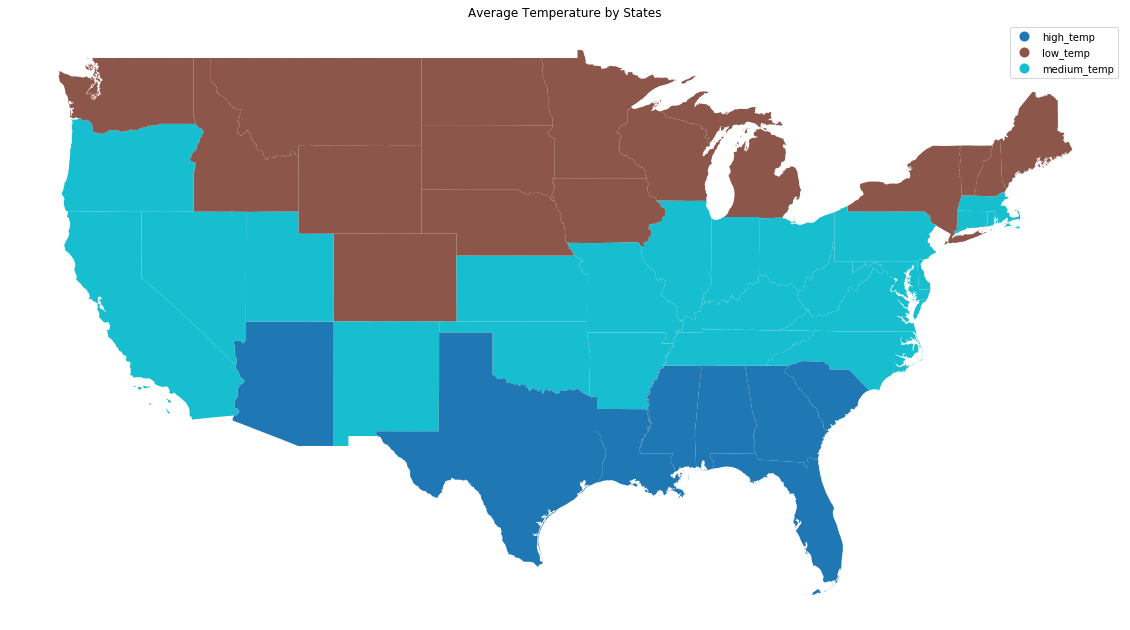

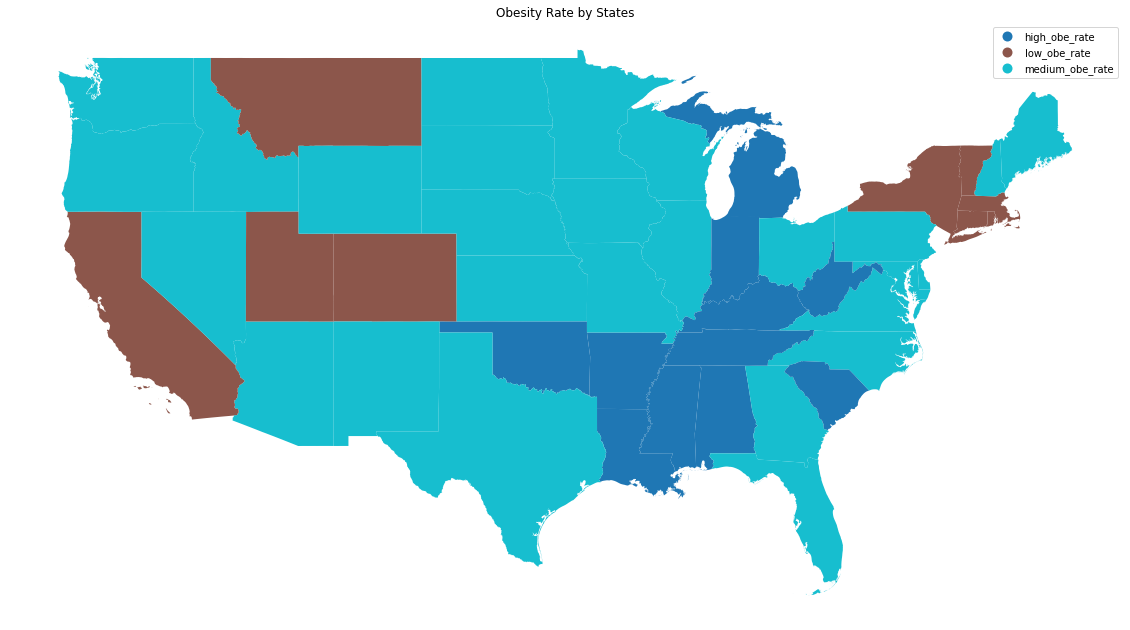

In [29]:
## YOUR CODE HERE
## FEEL FREE TO ADD MULTIPLE CELLS PER SECTION
ax1 = gdf.plot(column = 'temp_category', legend = True, markersize=20,figsize = (20,20))
ax1.set(title='Average Temperature by States')
ax1.set_axis_off()
ax2 = gdf.plot(column = 'obesity_category', legend = True, markersize=20,figsize = (20,20))
ax2.set(title='Obesity Rate by States')
ax2.set_axis_off()

#### Obeservation:

From the graphs of `Average Temperature by States` and `Obesity Rate by States`, we see that states in the northern United States tend to have medium and low obesity rates, while states with high average temperatures  located in the southern United States appear to have moderate and high obesity rates.

In [30]:
gdf.groupby('temp_category').count().states.to_frame().reset_index()

,temp_category,states
0,high_temp,8
1,low_temp,16
2,medium_temp,23


In [31]:
gdf.groupby('obesity_category').count().states.to_frame().reset_index()

,obesity_category,states
0,high_obe_rate,11
1,low_obe_rate,9
2,medium_obe_rate,27


#### Bar graph of Count of Average Temperature/ Obesity Rate categories by States

[Text(0.5, 1.0, 'Count of Obesity Rate categories by States')]

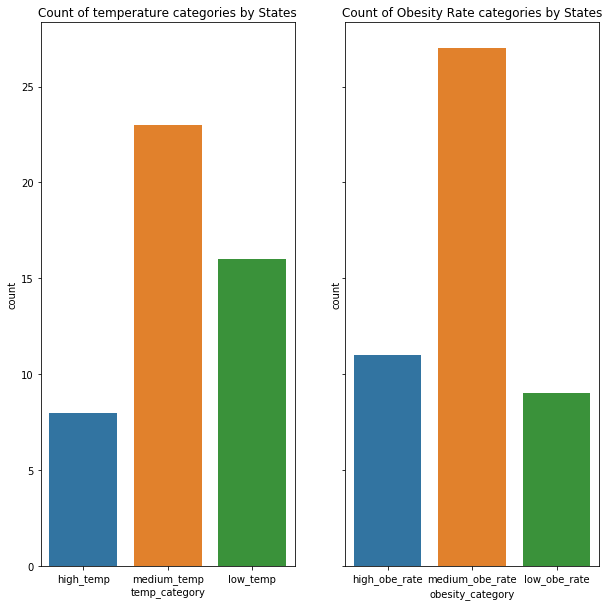

In [32]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, sharey = True)
fig.set_figheight(10)
fig.set_figwidth(10)
sns.countplot(x='temp_category',data=gdf, ax = ax1)
sns.countplot(x='obesity_category',data=gdf, ax = ax2)
ax1.set(title='Count of temperature categories by States')
ax2.set(title='Count of Obesity Rate categories by States')

#### Scatterplot of `Relationship between Obesity Rate and States Average Temperature`

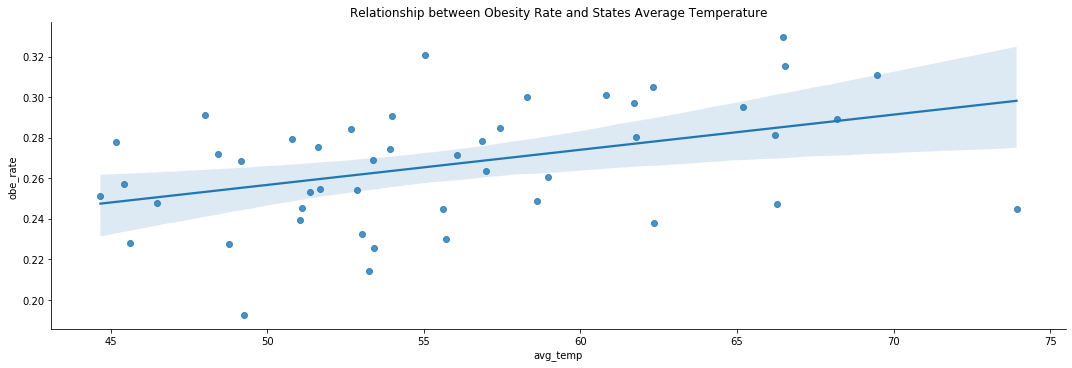

In [33]:
ax = sns.lmplot(x = 'avg_temp',
           y = 'obe_rate',
           data = gdf,aspect = 3)
ax.set(title = 'Relationship between Obesity Rate and States Average Temperature')

#### Obeservation:

From the scatterplot `Relationship between Obesity Rate and States Average Temperature`, we see there is a positive relationship between Obesity Rate and States Average Temperature.

#### OLS of States Average Temperature  and States Average Obesity Rate

In [34]:
outcome_1,predictors_1 = patsy.dmatrices('obe_rate ~ avg_temp',gdf)
mod_1= sm.OLS(outcome_1,predictors_1)
res_1 = mod_1.fit()
res_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               obe_rate   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     9.640
Date:                Sat, 12 Mar 2022   Prob (F-statistic):            0.00329
Time:                        15:09:50   Log-Likelihood:                 103.67
No. Observations:                  47   AIC:                            -203.3
Df Residuals:                      45   BIC:                            -199.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1699      0.031      5.398      0.000       0.106       0.233
avg_temp       0.0017      0.001      3.105      0.003       0.001       0.003
==============================================================================
Omnibus:                        1.411   Durbin-Watson:                   1.643
Prob(Omnibus):                  0.494   Jarque-Bera (JB):                1.408
Skew:                          -0.358   Prob(JB):                        0.495
Kurtosis:                       2.546   Cond. No.                         446.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Obeservation: 

Above OLS tells us the relationship between the average temperature from each state and average obesity rate. We use average temperature as independent variable and average obesity rate as dependent variable. The coefficient of average temperature is positive and its p-value is below $\alpha = 0.05%$ indicating the result is significant, showing that there is a positive relationship between the average temperature and average obesity rate in US.

#### Bar Graph of  `Mental illness percentage by State`

[Text(0.5, 1.0, 'States and mental illness percentage')]

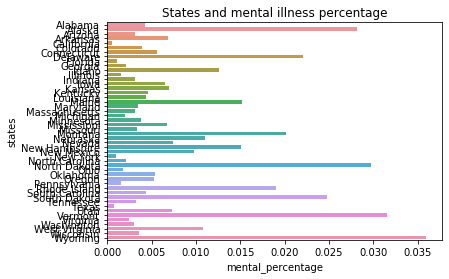

In [35]:
ax = sns.barplot(y = 'states', x = 'mental_percentage',data = new_merged)
ax.set(title = 'States and mental illness percentage')

#### Scatterplot of `Obesity Rate and States mental illness rate`

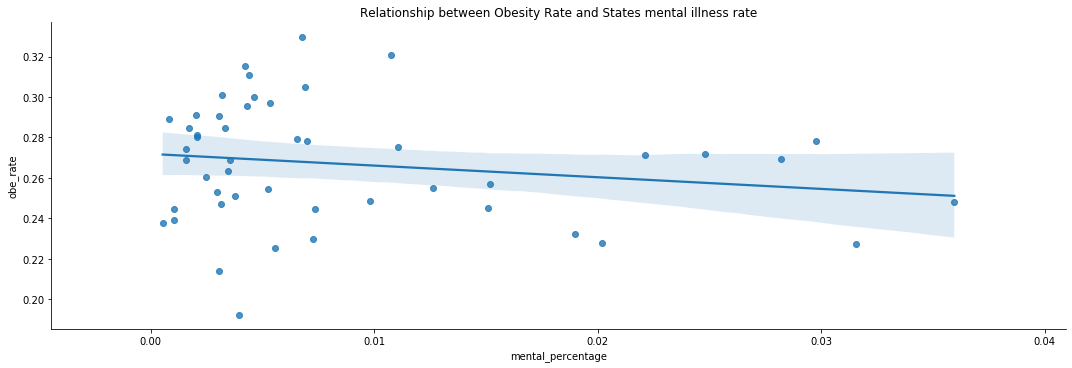

In [36]:
ax = sns.lmplot(x = 'mental_percentage',
                y = 'obe_rate',
                data = new_merged,
                aspect = 3)

ax.set(title = 'Relationship between Obesity Rate and States mental illness rate')

#### Obeservation:

From the scatterplot `Relationship between Obesity Rate and States mental illness rate`, we see there is a relative negative relationship between Obesity Rate and States mental_percentage.

#### OLS of States Average Obesity Rate and States Mental Pct

In [37]:
outcome_2,predictors_2 = patsy.dmatrices('obe_rate ~ mental_percentage', new_merged)
mod_2= sm.OLS(outcome_2,predictors_2)
res_2 = mod_2.fit()
res_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               obe_rate   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     1.500
Date:                Sat, 12 Mar 2022   Prob (F-statistic):              0.227
Time:                        15:09:51   Log-Likelihood:                 102.49
No. Observations:                  48   AIC:                            -201.0
Df Residuals:                      46   BIC:                            -197.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.2718      0.006     46.547      0.000       0.260       0.284
mental_percentage    -0.5763      0.471     -1.225      0.227      -1.523       0.371
==============================================================================
Omnibus:                        0.438   Durbin-Watson:                   1.747
Prob(Omnibus):                  0.803   Jarque-Bera (JB):                0.287
Skew:                          -0.186   Prob(JB):                        0.866
Kurtosis:                       2.929   Cond. No.                         112.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Obeservation: 

Above OLS tells us the relationship between the States Mental illness percentage and average obesity rate. We use States Mental illness percentage as independent variable and average obesity rate as dependent variable. The coefficient of average temperature is negative and its p-value is larger than $\alpha = 5\%$ indicating the result is `not significant`, showing that there might be a negative relationship between the States Mental illness percentage and States average obesity rate while is result is not significant.

#### Scatter Plot of `Relationship between Unemployment Rate and Obesity Rate by States`

Text(0.5, 0.98, 'Relationship between Unemployment Rate and Obesity Rate by States')

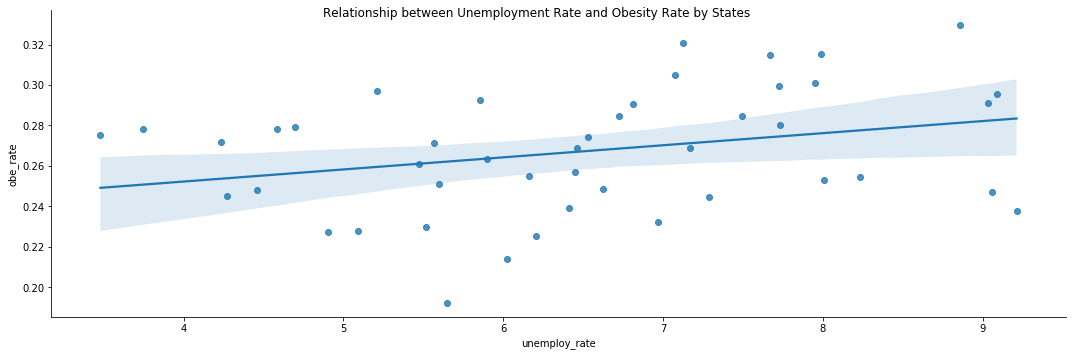

In [38]:
grouped_year = years_df.groupby('state').mean()
grouped_year = grouped_year.reset_index()
sns.lmplot(x = 'unemploy_rate', y = 'obe_rate',data = grouped_year, fit_reg=True, aspect = 3)\
                    .fig.suptitle("Relationship between Unemployment Rate and Obesity Rate by States")


#### Obeservation: 

From the scatterplot `Relationship between Unemployment Rate and Obesity Rate by States`, we see there is a relative positive relationship between States Unemployment Rate and States Obesity Rate.

#### OLS of States Average Obesity Rate and States Unemployment Rate

In [39]:
outcome_3,predictors_3 = patsy.dmatrices('obe_rate ~ unemploy_rate',grouped_year)
mod_3= sm.OLS(outcome_3,predictors_3)
res_3 = mod_3.fit()
res_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               obe_rate   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     4.161
Date:                Sat, 12 Mar 2022   Prob (F-statistic):             0.0475
Time:                        15:09:51   Log-Likelihood:                 96.111
No. Observations:                  45   AIC:                            -188.2
Df Residuals:                      43   BIC:                            -184.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.2283      0.020     11.687      0.000       0.189       0.268
unemploy_rate     0.0060      0.003      2.040      0.048    6.77e-05       0.012
==============================================================================
Omnibus:                        1.875   Durbin-Watson:                   1.879
Prob(Omnibus):                  0.392   Jarque-Bera (JB):                1.501
Skew:                          -0.273   Prob(JB):                        0.472
Kurtosis:                       2.291   Cond. No.                         30.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### observation:

The OLS tells us the relationship between the average unemployment rate and average obesity rate from 2003 - 2016. The p value is smaller than $\alpha = 5\%$ , and the coefficient is positive, so we claim that the result is statistically significant, which means there exisits a positive relationship between the average unemployment rate and average obesity rate in US.

#### Scatter Plot of ``Relationship between Income and Obesity Rate by States


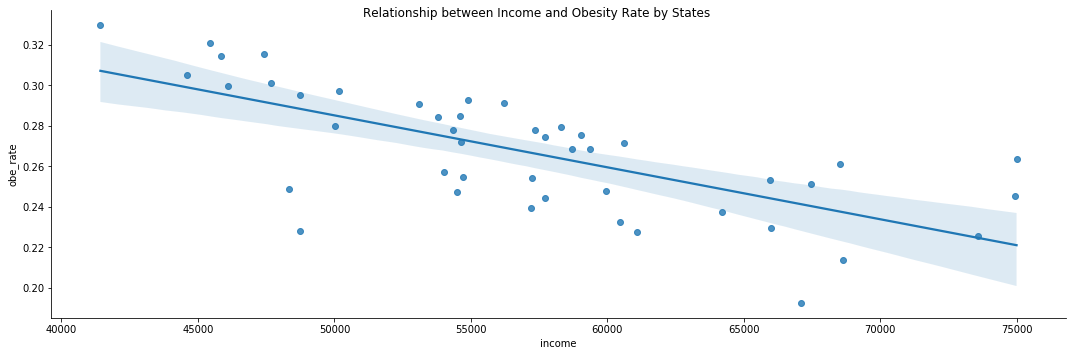

In [40]:
group_income = years_df.groupby('state').mean()
group_income = group_income.reset_index()
incomeplot = sns.lmplot(x = 'income',y='obe_rate', data = group_income, fit_reg = True,aspect = 3)\
                    .fig.suptitle("Relationship between Income and Obesity Rate by States")

####  Obeservation: 

From the scatterplot `Relationship between Income and Obesity Rate by States`, we see there is a relative negative relationship between States Unemployment Rate and States Obesity Rate.

#### OLS of States Average Obesity Rate and Average States income

In [41]:
outcome_4,predictors_4 = patsy.dmatrices('obe_rate ~ income', group_income)
mod_4= sm.OLS(outcome_4,predictors_4)
res_4 = mod_4.fit()
res_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               obe_rate   R-squared:                       0.489
Model:                            OLS   Adj. R-squared:                  0.477
Method:                 Least Squares   F-statistic:                     41.10
Date:                Sat, 12 Mar 2022   Prob (F-statistic):           9.23e-08
Time:                        15:09:52   Log-Likelihood:                 109.13
No. Observations:                  45   AIC:                            -214.3
Df Residuals:                      43   BIC:                            -210.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4132      0.023     17.960      0.000       0.367       0.460
income     -2.561e-06   3.99e-07     -6.411      0.000   -3.37e-06   -1.76e-06
==============================================================================
Omnibus:                        5.321   Durbin-Watson:                   2.402
Prob(Omnibus):                  0.070   Jarque-Bera (JB):                4.497
Skew:                          -0.767   Prob(JB):                        0.106
Kurtosis:                       3.207   Cond. No.                     4.06e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.06e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### observation:

Above OLS tells us the relationship between the Average States Income percentage and Average State Obesity rate. We use Average States Income percentage as independent variable and average obesity rate as dependent variable. The coefficient of Average States Income percentage is negative and its p-value is less than $\alpha = 1\%$ indicating the result is `very significant`, showing that there is be a negative relationship between the Average States Income and Average States Obesity rate, implying people care more about their body build as they get richer.